In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import urllib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv("SARCASMMMIXEDD.csv",on_bad_lines='skip')
df = df[['comment', 'label']]

print(df.head())
print('\n ', df.shape)

text = np.array(df['comment'].values)
label = np.array(df['label'].values)

                                             comment  label
0  I, for one, welcome this - it could lead to a ...      1
1                                       This is true      0
2  Yeah they still believed in bad humours and bl...      1
3  R9 390 has 8gb vram therefore it must be even ...      1
4                           Probably should've put a      1

  (1732, 2)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1732 non-null   object
 1   label    1732 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.2+ KB


In [ ]:
#checking for null values in train data
df.isnull().sum()

comment    0
label      0
dtype: int64

In [ ]:
df.describe(include='object')

,comment
count,1732
unique,1731
top,You forgot
freq,2


In [ ]:
df=df.drop(df[df['comment'].duplicated()].index,axis=0)

In [ ]:
import re
import string
from nltk.corpus import stopwords

# Initialize stopwords and punctuation
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing the stopwords from text
def split_into_words(text):
    # Split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # Convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # Prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # Remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # Remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # Filter out stop words
    words = [w for w in words if not w in stop]
    return words

def remove_hashtags(words):
    # Remove words that start with #
    words = [word for word in words if not word.startswith('#')]
    return words

def to_sentence(words):
    # Join words to a sentence
    return ' '.join(words)

# Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    words = remove_hashtags(words)  # Remove hashtags
    return to_sentence(words)

# Example usage
example_text = "This is an example text with a #hashtag and some punctuation!"
cleaned_text = denoise_text(example_text)
print("Cleaned Text:", cleaned_text)


Cleaned Text: example text hashtag punctuation


In [ ]:
df['comment'] = df['comment'].astype(str) #deleting duplicate

In [ ]:
#Apply function on review column
df['comment']=df['comment'].apply(denoise_text)

In [ ]:
labels = (df['label'])
data = (df['comment'])

In [ ]:
train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

train_text = data[:train_size]
train_label = labels[:train_size]

test_text = data[train_size:]
validation_label = labels[train_size:]

In [ ]:
pad_type = 'post'
trunc_type = 'post'
word_count = 10000 
max_len = 32
threshold = 0.99
batch_size = 50

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer

train_data = pd.Series(train_text).fillna('<OOV>').astype(str).tolist()
test_data = pd.Series(test_text).fillna('<OOV>').astype(str).tolist()

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

train_seq = tokenizer.texts_to_sequences(train_data)
validation_seq = tokenizer.texts_to_sequences(test_data)

test_seq = tokenizer.texts_to_sequences(test_data)

test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, padding=pad_type, truncating=trunc_type, maxlen=max_len)


4445


In [ ]:
print(train_text[1])
print(train_seq[1])
print(train_label[1])

true
[147]
0


In [ ]:
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, padding = pad_type, truncating = trunc_type, maxlen = max_len)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_seq, padding  = pad_type, truncating = trunc_type, maxlen = max_len)

In [ ]:
print(train_padded.shape)
print(validation_padded.shape)

(1384, 32)
(347, 32)


In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(word_count, 16, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid),
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            12544     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > threshold:
            self.model.stop_training = True
            print(' \n Terminating training as model reached ' + str(threshold * 100) + ' % accuracy \n')

callback_func = myCallback()

In [ ]:
history = model.fit(train_padded, train_label, validation_data=(validation_padded, validation_label), epochs = 5, batch_size=batch_size, callbacks = [callback_func], verbose=1)


Epoch 1/5
28/28 [==============================] - 22s 153ms/step - loss: 0.6121 - accuracy: 0.7254 - val_loss: 0.5367 - val_accuracy: 0.7983
Epoch 2/5
28/28 [==============================] - 3s 101ms/step - loss: 0.5877 - accuracy: 0.7305 - val_loss: 0.5339 - val_accuracy: 0.7983
Epoch 3/5
28/28 [==============================] - 3s 121ms/step - loss: 0.5581 - accuracy: 0.7305 - val_loss: 0.5643 - val_accuracy: 0.7983
Epoch 4/5
28/28 [==============================] - 2s 79ms/step - loss: 0.3333 - accuracy: 0.8598 - val_loss: 1.0177 - val_accuracy: 0.6052
Epoch 5/5
28/28 [==============================] - 2s 86ms/step - loss: 0.0896 - accuracy: 0.9725 - val_loss: 1.2368 - val_accuracy: 0.6052


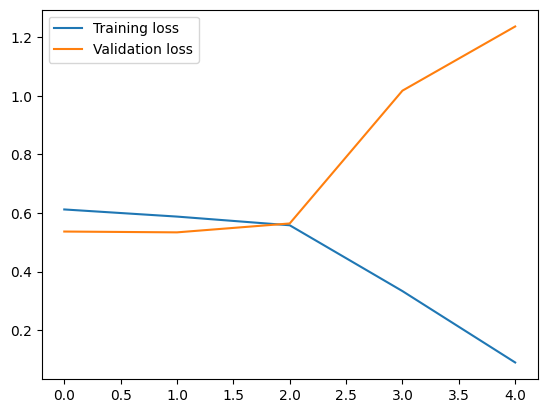

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

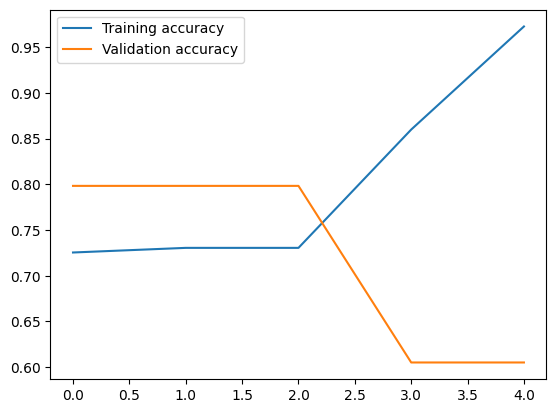

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [ ]:
test_labels = np.array(df['label'].values[train_size:])


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

test_predictions = model.predict(test_padded)
test_predictions = (test_predictions > 0.5).astype(int)  

print(f'Test predictions: {test_predictions[:10].flatten()}')
print(f'Test labels: {test_labels[:10]}')

accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {accuracy}')

precision = precision_score(test_labels, test_predictions)
print(f'Precision: {precision}')

recall = recall_score(test_labels, test_predictions)
print(f'Recall: {recall}')

f1 = f1_score(test_labels, test_predictions)
print(f'F1 Score: {f1}')


11/11 [==============================] - 4s 39ms/step
Test predictions: [1 1 1 0 0 1 1 1 1 1]
Test labels: [1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.6051873198847262
Precision: 0.7991452991452992
Recall: 0.6750902527075813
F1 Score: 0.7318982387475539
